In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats
import seaborn as sns
import missingno as msno

In [3]:
# loan data
loans = pd.read_csv("./Data/Credit_Card.csv")
loans.drop(columns=loans.columns[0],inplace=True)

# display
loans.head()

,ID,gender,car,realty,children_count,income_amount,income_type,education_type,family_status,housing_type,mobile,work_phone,phone,email,occupation_type,family_members,status,age,working_yr
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0.0,32,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0.0,32,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0.0,58,3
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0.0,52,8
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0.0,52,8


# 1 Pre-processing
## 1.1 Drop duplication

In [4]:
loans.drop_duplicates(inplace = True)
loans.index = range(loans.shape[0])

## 1.2 Missing values 

When encountering a missing data, to determine the type of missing data is important, In generally, there are 3 common mechanisms:

* Structural deficiencies in the data
* Random occurrences - MCAR and MAR
* Specific cause -  NMAR.

### <strong> 1.2.1 Structural deficiencies </strong>
Structurally missing data is data that is missing for a logical reason. In other words, it is data that is missing because it should not exist. For example, many observations have missing values for occupation. This is because these people dont have job. 

In this situation, <strong> encoding missingness </strong> is a good choice. In other words,a better recording for the occupation might be to <strong>replace with “None” </strong> 

### <strong>  1.2.2 MCAR and MAR </strong>
For random occurrences, there two categories:
* Missing completetely at random(MCAR): the missing values are independent of the data
* Missing at Random (MAR): the missing values are dependent on oberved data.  

There is a example for MAR. 
| ID       |  gender   |  Age        | income    |
|----------| ----------| ----------  | ----------| 
| 1        | Male      |  Under 30   |   Low     | 
| 2        | Female    |  Under 30   |   Low     |
| 3        | Female    |  30 or more |   High    |
| 4        | Female    |  30 or more |           |
| 5        | Female    |  30 or More |   High    | 

For ID 4,we can predict the value based on the other data, so she has more probability to have a high income. In the practice, we can use <strong>imputation method</strong> , like K-Nearest Neighbors,Random Forest, and so on, or other algorithms specifically designed for missing values. 

But data with MCAR, we cannot find any pattern. If the deletion of data less likely cause bias, the missing values can be extricated from the data  

### <strong>  1.2.3 NMAR  </strong>
The missing data caused by specific cause also call not missing at random (NMAR). For example, Take the income as an example. clients with high income more likely provide income statement in order to obtain higher credit limits. In this situation, we can assume that clients with missing values in income have lower salary. 

Reference:  
[Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/index.html)

[What are the Different Types of Missing Data?](https://www.displayr.com/different-types-of-missing-data/)

occupation_type    0.307286
dtype: float64


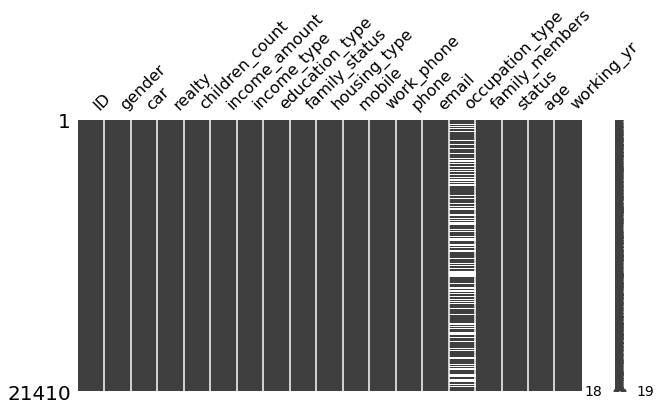

In [5]:
# check factors with missing values
print(loans.isnull().mean()[loans.isnull().mean() > 0])

# visualizing the loaction of the missing data
msno.matrix(loans,figsize=(10,5))
plt.show()

There is only one feature with missing values which is over 30% . In order to understand the missing data, communicating with data collector is critical. But This dataset come from Kaggle. So according to my own experience, this is structual miising data. 

In [6]:
print(loans["occupation_type"].value_counts(dropna = False))

NaN                      6579
Laborers                 3612
Core staff               2156
Sales staff              1939
Managers                 1858
Drivers                  1305
High skill tech staff     901
Accountants               753
Medicine staff            729
Cooking staff             374
Security staff            336
Cleaning staff            312
Private service staff     182
Low-skill Laborers        100
Secretaries                87
Waiters/barmen staff       74
HR staff                   45
IT staff                   40
Realty agents              28
Name: occupation_type, dtype: int64


Since the occupation tpye is a categorical feature, we can directly switch the missing value to the string "Nan" as a category. 

In [7]:
# ecode missing data
loans.replace(np.nan,"Nan",inplace=True)

## 1.3 Outlier
<strong> A) Univariate Outliers:  </strong>  
<strong> 1) Interquartile Range Method </strong>   
First setp is to calculate first quartile(Q1), median, and third quartile(Q3). The IQR is the difference between Q3 and Q1. 
The outliers are 

$$< Q1 − 1.5 \times IQR$$
$$> Q3 + 1.5 \times IQR $$

<strong> 2) Standard Deviation Method </strong>   
If distribution of data is approximately nomrl, then 68% of the data values lie within one standard deviation of the mean and about 95% are within two standard deviations, and about 99.7% lie within three standard deviations. In general, 3 $\sigma$ is used to identify outliers. 

$$M< \mu - 3\sigma$$
$$M> \mu + 3\sigma$$

<strong>3) Z-Score method </strong>  
It is similar to Second method. This technique assumes a Gaussian distribution of the data. The outliers are the data points that are in the tails of the distribution and therefore far from the mean.

$$Z-core = \frac{(x - \mu)}{\sigma}$$
$$ \lvert Z\_score \lvert > Zthr $$

<strong> 4) Isolation Forest </strong>  

How many splits does take simple point to the isolated 
1. randomly selecting a point to isolate
2. randomly selecting a split point between the max and min 
   * If the chosen value keeps the point above, switch the minimum of the range of the feature to the value.
   * If the chosen value keeps the point below, switch the maximum of the range of the feature to the value
3. repeat 2 until the point isolated
4. Count how many time repeat step 2, which is isolation number

The isolation number of outlier significantly less than that of non-outlier. 

<strong> B) Mulitivariate Outliers: </strong>  
<strong> 1) DBSCAN </strong> 
   
DBSCAN is (Density-Based Spatial Clustering of Applications with Noise). The main idea behind that is one concept, two hyperparameters, and three types of points.  

One concept: DBSCAN groups together points that are close to each other based on a distance measurement and a minimum number of points.

Two hyperparameters:
* <strong> eps </strong>: The distance that specifies the neighborhoods  
* <strong> minPts </strong> : Minimum number of data points to define a cluster  

Three types of point:  
* <strong> Core point </strong>: A point is a core point if there are at least minPts number of points  in its surrounding area with radius eps.
* <strong> Border point</strong>: A point is a border point if it is reachable from a core point and there are less than minPts number of points within its surrounding area.
* <strong> Outlier</strong>: A point is an outlier if it is not a core point and not reachable from any core points.  

<div align=center> <img src="https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png" width = "20%"> </div> 

1) Local Outlier Factor Method(LOF)


  




1) Local Outlier Factor Method(LOF)
### <strong> 1.3.1 numberial features.</strong>

In [8]:
loans.loc[:,loans.dtypes != 'object'].drop(columns= ["ID","status","mobile", "work_phone", "phone", "email"]).describe().T

,count,mean,std,min,25%,50%,75%,max
children_count,21410.0,0.431527,0.739196,0.0,0.0,0.0,1.0,14.0
income_amount,21410.0,189277.247922,102002.349689,27000.0,126000.0,166500.0,225000.0,1575000.0
family_members,21410.0,2.211583,0.903683,1.0,2.0,2.0,3.0,15.0
age,21410.0,43.558524,11.219676,21.0,34.0,42.0,53.0,68.0
working_yr,21410.0,-155.301261,370.650445,-1001.0,1.0,4.0,8.0,43.0


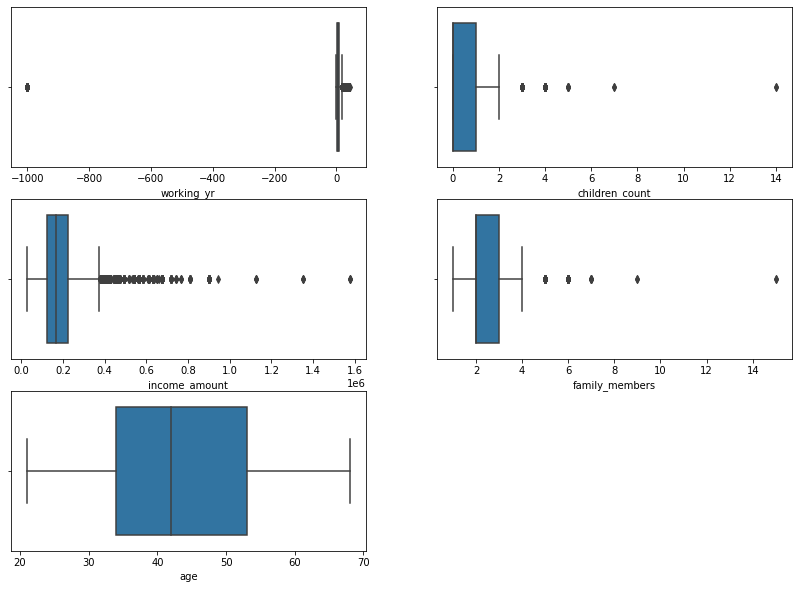

In [9]:
# Interquartile Range Method
# working_yr
plt.figure(figsize=(14,10))
ax = plt.subplot(3,2,1)
sns.boxplot(loans.working_yr)

# children_count
ax = plt.subplot(3,2,2)
sns.boxplot(loans.children_count)

# income_amount
ax = plt.subplot(3,2,3)
sns.boxplot(loans.income_amount)

# family_members
ax = plt.subplot(3,2,4)
sns.boxplot(loans.family_members)

# age
ax = plt.subplot(3,2,5)
sns.boxplot(loans.age)
plt.show()

Since we will do feature binning, the outlier is not the big issue for us. 

But there is abnormal values for years of working experience, which is negative, so we can delete such obervations. 

In [10]:
# number of abnormal values
print("Number of clients with years of working experience less than 0: {} ".format((loans.working_yr < 0).sum()))
print("Number of observations: {} ".format(loans.shape[0]))
print("Deletion does not cause the huge loss of obervations")

# drop the rows with negative working year
loans.drop(index = loans[loans["working_yr"] < 0]["ID"].index, inplace = True)
loans.reset_index(drop =True,inplace=True)

Number of clients with years of working experience less than 0: 3449 
Number of observations: 21410 
Deletion does not cause the huge loss of obervations


In [11]:
# check for columns with object features
for i in range((loans.dtypes == 'object').sum()):
    print("-"*50)
    print(loans.loc[:,loans.dtypes == 'object'].iloc[:,i].value_counts())

for x in ("mobile", "work_phone", "phone", "email"):
    print("-"*50)
    print(loans.loc[:,x].value_counts())
# mobile, work_phone, phone, email

--------------------------------------------------
F    11279
M     6682
Name: gender, dtype: int64
--------------------------------------------------
N    10273
Y     7688
Name: car, dtype: int64
--------------------------------------------------
Y    11434
N     6527
Name: realty, dtype: int64
--------------------------------------------------
Working                 11001
Commercial associate     5090
State servant            1844
Pensioner                  16
Student                    10
Name: income_type, dtype: int64
--------------------------------------------------
Secondary / secondary special    11629
Higher education                  5343
Incomplete higher                  820
Lower secondary                    144
Academic degree                     25
Name: education_type, dtype: int64
--------------------------------------------------
Married                 12846
Single / not married     2236
Civil marriage           1425
Separated                1063
Widow             

For mobile, it only has one value which is 1, which cannot provide us any useful information for our models, so we remove it from our dataset.  

In [12]:
loans.drop(columns = "mobile",inplace=True)

## 1.4 imbalance 

In [13]:
X = loans.drop(columns = ["status","ID"])
y = loans["status"]

0.0    17475
1.0      486
Name: status, dtype: int64
0 = No default,1= Default
--------------------------------------------------
Good Customers accounted for 97.29 % of the dataset
Bad Customers accounted for 2.71 % of the dataset



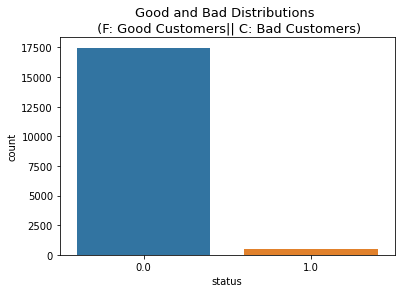

In [14]:
# number of Good and Bad Customers
print(y.value_counts())
print("0 = No default,1= Default")
print("-"*50)

# ratio of Good and Bad Customers
print('Good Customers accounted for', round(loans['status'].value_counts()[0]/len(loans['status']) * 100,2), '% of the dataset')
print('Bad Customers accounted for', round(loans['status'].value_counts()[1]/len(loans['status']) * 100,2), '% of the dataset')
print("")

# plot 
sns.countplot(loans['status'])
plt.title('Good and Bad Distributions \n (F: Good Customers|| C: Bad Customers)', fontsize=13)
plt.show()

In this sample size over the time interval, there are 17475 good customers and 486 bad customers. The bad customers accounted for approximately 2.71% of the sample size. Our goal is to be certain when the model predict correctly which customer is good or bad.

Imbalanced datasets are usually misleading about the accuracy of the model since the gap between good customers and bad customers is extremely high. If we do not randomized balanced out the good and bad customers, the algorithms will probably overfit since it will assume most of the clients are good. It will also gives us a wrong correlation between the features since the good customers dominated the sample size. By creating a balanced sub-sample which equal the amount of good and bad, we can eliminate the overfiting and helping algorithms achive better accuracy on classification results.

The SMOTE method can help us to solve such problem

In [15]:
# switch int to float
X.loc[:,["income_amount","age","working_yr"]] = X[["income_amount","age","working_yr"]].astype(float)

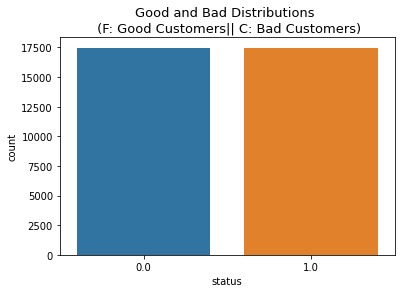

In [16]:
# deal with imbalance 
from imblearn.over_sampling import SMOTENC
smote_nc= SMOTENC(categorical_features=[0,1,2,3,5,6,7,8,9,10,11,12,13],random_state=42) 
X,y = smote_nc.fit_resample(X,y)

# plot 
sns.countplot(y)
plt.title('Good and Bad Distributions \n (F: Good Customers|| C: Bad Customers)', fontsize=13)
plt.show()

## 2 train & test split 

In [17]:
from sklearn.model_selection import train_test_split 
X = pd.DataFrame(X) 
y = pd.DataFrame(y)

X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3,random_state=420)

# data for train
model_data = pd.concat([Y_train, X_train], axis=1)
model_data.index = range(model_data.shape[0])
# data for test
test_data = pd.concat([Y_test, X_test], axis=1) 
test_data.index = range(test_data.shape[0])

# export the data 
model_data.to_csv("./Data/model_data.csv", index=False)
test_data.to_csv("./Data/test_data.csv",index=False)

## 3 Binning, WOE and IV
WOE Binning is to create new categorical features for all numberical and categorical features, which is the most critical steps. 

Firstly, the fewer number of bins, the more information will loss. But in order to built credit scorecard, the numbers of bins should be limited. In generally, less than 10 bins is recerivable, and optimail number is 4 - 5.

In order to meature information of features after binning, Weight of Evidence(WOE) and Information Value(IV) were introduced. 

WOE is a measure of the predictive power of an independent variable in relation to the target variable. In this case, it meature power of feature to separat good and bad clients. 

$$ W O E_{i}=\ln \left(\frac{g o o d \%}{b a d \%}\right) $$

IV ranks our feature based on their relative importance, which assists with selecting important features in a predictive model.

$$I V=\sum_{i=1}^{N}(g o o d \%-b a d \%) \times W O E_{i}$$

<strong> Rules related to Information Value </strong>  

|Information Value	| Variable Predictiveness|
|------------------ | ---------------------- |
|Less than 0.02	    |Not useful for prediction|
|0.02 to 0.1	    |Weak predictive Power|
|0.1 to 0.3	        |Medium predictive Power|
|0.3 to 0.5	        |Strong predictive Power|
|>0.5	            | Suspicious Predictive Power|

Steps: 
<strong> 1) binning </strong>  
The most widely used binning algorithm is Chi-merge. Chi-merge is a process of dividing into intervals (bins) in the way that neighboring bins will differ from each other as much as possible in the ratio of “Good” and “Bad” records in them.

<strong> 2）Analysis and manual correction of binning  </strong>  
After taken 10 - 20 bins, we can oberve the relatinship between IV and number of bins tp identify the optimal number of bins. There is trade-off. And the WOE should be monotonic. 

referenc:   
[Scorecard Development Stage](https://plug-n-score.com/learning/scorecard-development-stages.htm#Binning)

[WEIGHT OF EVIDENCE (WOE) AND INFORMATION VALUE (IV) EXPLAINED](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)


In [18]:
# load the data
model_data= pd.read_csv('./Data/model_data.csv', low_memory=True)
test_data = pd.read_csv('./Data/model_data.csv', low_memory=True) 

In [19]:
fatures = model_data.drop(columns="status")
count_values = pd.DataFrame(columns=["counts"])
for i in fatures.columns[1:]:
    count_values.loc[i]=len(fatures[i].value_counts())

print("Distinguish types of features")
count_values

Distinguish types of features


,counts
car,2
realty,2
children_count,8
income_amount,1495
income_type,5
education_type,5
family_status,5
housing_type,6
work_phone,2
phone,2


For the binary features, we donot need to do binning

## 3.1 binary features

In [20]:
binary_features = count_values.sort_values("counts")[count_values.sort_values("counts").values == 2]
binary_features

,counts
car,2
realty,2
work_phone,2
phone,2
email,2


In [21]:
def get_woe(feature):

    df = feature
    df.fillna(0,inplace=True)

    df["total"] = df.count_0 + df.count_1 
    df["percentage"] = df.total / df.total.sum() 
    df["bad_rate"] = df.count_1 / df.total 
    df["good%"] = df.count_0/df.count_0.sum() 
    df["bad%"] = df.count_1/df.count_1.sum()
    df["woe"] = np.log(df["good%"] / df["bad%"])
    
    df.replace(np.inf, 0, inplace=True)
    
    return df


def get_iv(df):
    
    rate = df["good%"] - df["bad%"]
    iv = np.sum(rate * df.woe) 
    
    return iv

In [22]:
# compute woe for binary features 
woe = pd.DataFrame()
for i in list(binary_features.index):
    woe_each = pd.DataFrame()
    woe_each ["count_0"] = model_data.groupby(i)["status"].value_counts().loc[:,0]
    woe_each ["count_1"] = model_data.groupby(i)["status"].value_counts().loc[:,1]
    woe_each ["features"] = i
    woe_each = woe_each.reset_index().set_index(keys=["features",i])
    woe_each.index.set_names(names="class",level=1,inplace=True)
    woe_each = get_woe(woe_each)
    woe = woe.append(woe_each)
display(woe)
print("-"*100)

IV = pd.DataFrame(columns=["IV"])
for i in list(binary_features.index):                                     
    IV.loc[i] = get_iv(woe.loc[[i,]])
display(IV.sort_values("IV",ascending = False))

count_0  count_1  total  percentage  bad_rate     good%  \
features   class                                                            
car        N         6913     7508  14421    0.589454  0.520630  0.569112   
           Y         5234     4810  10044    0.410546  0.478893  0.430888   
realty     N         4426     4334   8760    0.358063  0.494749  0.364370   
           Y         7721     7984  15705    0.641937  0.508373  0.635630   
work_phone 0         8792     9213  18005    0.735949  0.511691  0.723800   
           1         3355     3105   6460    0.264051  0.480650  0.276200   
phone      0         8500     8840  17340    0.708768  0.509804  0.699761   
           1         3647     3478   7125    0.291232  0.488140  0.300239   
email      0        10869    11824  22693    0.927570  0.521042  0.894789   
           1         1278      494   1772    0.072430  0.278781  0.105211   

                      bad%       woe  
features   class                      
car        N      0.609515 -0.068586  
           Y      0.390485  0.098458  
realty     N      0.351843  0.034985  
           Y      0.648157 -0.019516  
work_phone 0      0.747930 -0.032794  
           1      0.252070  0.091417  
phone      0      0.717649 -0.025241  
           1      0.282351  0.061427  
email      0      0.959896 -0.070237  
           1      0.040104  0.964495

----------------------------------------------------------------------------------------------------


,IV
email,0.067369
car,0.006749
work_phone,0.002997
phone,0.001550
realty,0.000683


## 3.2 Categorical Features

In [23]:
mask = count_values.sort_values("counts")
categorical_features = mask[(mask.values < 20) & (mask.values >2)]
categorical_features

,counts
income_type,5
education_type,5
family_status,5
housing_type,6
children_count,8
family_members,9
occupation_type,19


In [24]:
def get_feature_woe(feature_name):
    woe_each = pd.DataFrame()
    woe_each ["count_0"] = model_data.groupby(feature_name)["status"].value_counts().loc[:,0]
    woe_each ["count_1"] = model_data.groupby(feature_name)["status"].value_counts().loc[:,1]
    woe_each ["features"] = feature_name
    woe_each = woe_each.reset_index().set_index(keys=["features",feature_name])
    woe_each.index.set_names(names="class",level=1,inplace=True)
    woe_each = get_woe(woe_each)
    woe_each.sort_values(by="bad_rate",inplace=True)
    return woe_each

def chi_pv(feature):
    df = pd.DataFrame()
    df["count_0"] = model_data.groupby(feature)["status"].value_counts().loc[:,0]
    df["count_1"] = model_data.groupby(feature)["status"].value_counts().loc[:,1]

    pv_list = pd.DataFrame(columns=["x1","x2","pv"])
    for i in range(len(df)):
        for x in range(i+1,len(df),1):
            x1 = df.iloc[i]
            x2 = df.iloc[x]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pv_list = pv_list.append([{"x1":x1.name,"x2":x2.name,"pv":pv}],ignore_index=True)
    return pv_list

In [25]:
woe = pd.DataFrame()
for i in list(categorical_features.index):
    woe_each = get_feature_woe(i)
    woe = woe.append(woe_each)
woe

count_0  count_1    total  \
features        class                                                      
income_type     Student                              8      0.0      8.0   
                State servant                     1247    239.0   1486.0   
                Commercial associate              3424   3545.0   6969.0   
                Working                           7468   8491.0  15959.0   
education_type  Academic degree                     15      0.0     15.0   
                Lower secondary                     91     41.0    132.0   
                Higher education                  3629   2997.0   6626.0   
                Incomplete higher                  544    480.0   1024.0   
                Secondary / secondary special     7868   8800.0  16668.0   
family_status   Separated                          716    266.0    982.0   
                Civil marriage                     989    870.0   1859.0   
                Single / not married              1489   1415.0   2904.0   
                Married                           8682   9448.0  18130.0   
                Widow                              271    319.0    590.0   
housing_type    Co-op apartment                     70      2.0     72.0   
                Rented apartment                   180      7.0    187.0   
                With parents                       656    263.0    919.0   
                Municipal apartment                396    165.0    561.0   
                Office apartment                    76     49.0    125.0   
                House / apartment                10769  11832.0  22601.0   
children_count  5                                    5      0.0      5.0   
                7                                    1      0.0      1.0   
                14                                   1      0.0      1.0   
                4                                   28      1.0     29.0   
                2                                 1298    815.0   2113.0   
                1                                 2929   2436.0   5365.0   
                3                                  167    162.0    329.0   
                0                                 7718   8904.0  16622.0   
family_members  7                                    4      0.0      4.0   
                9.0                                  1      0.0      1.0   
                15.0                                 1      0.0      1.0   
                6.0                                 27      1.0     28.0   
                4                                 1239    856.0   2095.0   
                3                                 2499   2149.0   4648.0   
                1                                 1912   2028.0   3940.0   
                5                                  165    177.0    342.0   
                2                                 6299   7107.0  13406.0   
occupation_type Realty agents                       15      0.0     15.0   
                HR staff                            36      1.0     37.0   
                Cleaning staff                     209     23.0    232.0   
                Waiters/barmen staff                53     12.0     65.0   
                Private service staff              129     30.0    159.0   
                Medicine staff                     503    181.0    684.0   
                Low-skill Laborers                  63     38.0    101.0   
                Nan                               2080   1652.0   3732.0   
                Sales staff                       1316   1125.0   2441.0   
                Accountants                        533    458.0    991.0   
                Cooking staff                      247    226.0    473.0   
                Managers                          1270   1179.0   2449.0   
                Core staff                        1431   1460.0   2891.0   
                Security staff                     214    227.0    441.0   
                Sec

## 3.2.1 income_type

In [26]:
get_feature_woe("income_type")

count_0  count_1    total  percentage  \
features    class                                                         
income_type Student                     8      0.0      8.0    0.000328   
            State servant            1247    239.0   1486.0    0.060847   
            Commercial associate     3424   3545.0   6969.0    0.285357   
            Working                  7468   8491.0  15959.0    0.653468   

                                  bad_rate     good%      bad%       woe  
features    class                                                         
income_type Student               0.000000  0.000659  0.000000  0.000000  
            State servant         0.160834  0.102659  0.019470  1.662515  
            Commercial associate  0.508681  0.281880  0.288798 -0.024246  
            Working               0.532051  0.614802  0.691731 -0.117897

In [27]:
# since there are only 11 students, so we drop them
model_data =model_data.replace(["Student","State servant","Pensioner"],"Student / State servant / Pensioner")
test_data =test_data.replace(["Student","State servant","Pensioner"],"Student / State servant / Pensioner")
get_feature_woe("income_type")

count_0  count_1  total  \
features    class                                                          
income_type Student / State servant / Pensioner     1255      282   1537   
            Commercial associate                    3424     3545   6969   
            Working                                 7468     8491  15959   

                                                 percentage  bad_rate  \
features    class                                                       
income_type Student / State servant / Pensioner    0.062824  0.183474   
            Commercial associate                   0.284856  0.508681   
            Working                                0.652320  0.532051   

                                                    good%      bad%       woe  
features    class                                                              
income_type Student / State servant / Pensioner  0.103318  0.022893  1.506963  
            Commercial associate                 0.281880  0.287790 -0.020749  
            Working                              0.614802  0.689316 -0.114400

In [28]:
# chi
mask= chi_pv("income_type")
display(mask[mask["pv"]>0.9])

,x1,x2,pv


## 3.2.2 education_type

In [29]:
display(get_feature_woe("education_type"))

count_0  count_1    total  \
features       class                                                      
education_type Academic degree                     15      0.0     15.0   
               Lower secondary                     91     41.0    132.0   
               Higher education                  3629   2997.0   6626.0   
               Incomplete higher                  544    480.0   1024.0   
               Secondary / secondary special     7868   8800.0  16668.0   

                                              percentage  bad_rate     good%  \
features       class                                                           
education_type Academic degree                  0.000613  0.000000  0.001235   
               Lower secondary                  0.005395  0.310606  0.007492   
               Higher education                 0.270836  0.452309  0.298757   
               Incomplete higher                0.041856  0.468750  0.044785   
               Secondary / secondary special    0.681300  0.527958  0.647732   

                                                  bad%       woe  
features       class                                              
education_type Academic degree                0.000000  0.000000  
               Lower secondary                0.003328  0.811267  
               Higher education               0.243302  0.205325  
               Incomplete higher              0.038967  0.139143  
               Secondary / secondary special  0.714402 -0.097968

In [30]:
model_data =model_data.replace(["Academic degree","Higher education"],"Academic degree / Higher education")
test_data =test_data.replace(["Academic degree","Higher education"],"Academic degree / Higher education")
get_feature_woe("education_type")

count_0  count_1  total  \
features       class                                                         
education_type Lower secondary                          91       41    132   
               Academic degree / Higher education     3644     2997   6641   
               Incomplete higher                       544      480   1024   
               Secondary / secondary special          7868     8800  16668   

                                                   percentage  bad_rate  \
features       class                                                      
education_type Lower secondary                       0.005395  0.310606   
               Academic degree / Higher education    0.271449  0.451287   
               Incomplete higher                     0.041856  0.468750   
               Secondary / secondary special         0.681300  0.527958   

                                                      good%      bad%  \
features       class                                                    
education_type Lower secondary                     0.007492  0.003328   
               Academic degree / Higher education  0.299992  0.243302   
               Incomplete higher                   0.044785  0.038967   
               Secondary / secondary special       0.647732  0.714402   

                                                        woe  
features       class                                         
education_type Lower secondary                     0.811267  
               Academic degree / Higher education  0.209450  
               Incomplete higher                   0.139143  
               Secondary / secondary special      -0.097968

In [31]:
mask= chi_pv("education_type")
display(mask[mask["pv"]>0.9])

,x1,x2,pv


In [32]:
model_data =model_data.replace(["Academic degree / Higher education","Incomplete higher"],"Academic degree / Higher education / Incomplete higher")
test_data =test_data.replace(["Academic degree / Higher education","Incomplete higher"],"Academic degree / Higher education / Incomplete higher")
get_feature_woe("education_type")

count_0  \
features       class                                                         
education_type Lower secondary                                          91   
               Academic degree / Higher education / Incomplete...     4188   
               Secondary / secondary special                          7868   

                                                                   count_1  \
features       class                                                         
education_type Lower secondary                                          41   
               Academic degree / Higher education / Incomplete...     3477   
               Secondary / secondary special                          8800   

                                                                   total  \
features       class                                                       
education_type Lower secondary                                       132   
               Academic degree / Higher education / Incomplete...   7665   
               Secondary / secondary special                       16668   

                                                                   percentage  \
features       class                                                            
education_type Lower secondary                                       0.005395   
               Academic degree / Higher education / Incomplete...    0.313305   
               Secondary / secondary special                         0.681300   

                                                                   bad_rate  \
features       class                                                          
education_type Lower secondary                                     0.310606   
               Academic degree / Higher education / Incomplete...  0.453620   
               Secondary / secondary special                       0.527958   

                                                                      good%  \
features       class                                                          
education_type Lower secondary                                     0.007492   
               Academic degree / Higher education / Incomplete...  0.344776   
               Secondary / secondary special                       0.647732   

                                                                       bad%  \
features       class                                                          
education_type Lower secondary                                     0.003328   
               Academic degree / Higher education / Incomplete...  0.282270   
               Secondary / secondary special                       0.714402   

                                                                        woe  
features       class                                                         
education_type Lower secondary                                     0.811267  
               Academic degree / Higher education / Incomplete...  0.200033  
               Secondary / secondary special                      -0.097968

In [33]:
mask= chi_pv("education_type")
display(mask[mask["pv"]>0.9])

,x1,x2,pv


## 3.2.3 family_status

In [34]:
display(get_feature_woe("family_status"))
mask= chi_pv("family_status")
display(mask[mask["pv"]>0.9])

count_0  count_1  total  percentage  \
features      class                                                       
family_status Separated                 716      266    982    0.040139   
              Civil marriage            989      870   1859    0.075986   
              Single / not married     1489     1415   2904    0.118700   
              Married                  8682     9448  18130    0.741059   
              Widow                     271      319    590    0.024116   

                                    bad_rate     good%      bad%       woe  
features      class                                                         
family_status Separated             0.270876  0.058945  0.021594  1.004163  
              Civil marriage        0.467994  0.081419  0.070628  0.142181  
              Single / not married  0.487259  0.122582  0.114873  0.064955  
              Married               0.521125  0.714744  0.767008 -0.070572  
              Widow                 0.540678  0.022310  0.025897 -0.149093

,x1,x2,pv


## 3.2.4 housing_type

In [35]:
display(get_feature_woe("housing_type"))
mask= chi_pv("housing_type")
display(mask[mask["pv"]>0.9])

count_0  count_1  total  percentage  \
features     class                                                      
housing_type Co-op apartment           70        2     72    0.002943   
             Rented apartment         180        7    187    0.007644   
             With parents             656      263    919    0.037564   
             Municipal apartment      396      165    561    0.022931   
             Office apartment          76       49    125    0.005109   
             House / apartment      10769    11832  22601    0.923810   

                                  bad_rate     good%      bad%       woe  
features     class                                                        
housing_type Co-op apartment      0.027778  0.005763  0.000162  3.569327  
             Rented apartment     0.037433  0.014818  0.000568  3.261026  
             With parents         0.286181  0.054005  0.021351  0.927986  
             Municipal apartment  0.294118  0.032601  0.013395  0.889448  
             Office apartment     0.392000  0.006257  0.003978  0.452892  
             House / apartment    0.523517  0.886556  0.960546 -0.080157

,x1,x2,pv
3,Co-op apartment,Rented apartment,0.998834


In [36]:
model_data =model_data.replace(["Co-op apartment","Rented apartment"],"Co-op apartment / Rented apartment")
test_data =test_data.replace(["Co-op apartment","Rented apartment"],"Co-op apartment / Rented apartment")
display(get_feature_woe("housing_type"))

mask= chi_pv("housing_type")
display(mask[mask["pv"]>0.9])

count_0  count_1  total  \
features     class                                                         
housing_type Co-op apartment / Rented apartment      250        9    259   
             With parents                            656      263    919   
             Municipal apartment                     396      165    561   
             Office apartment                         76       49    125   
             House / apartment                     10769    11832  22601   

                                                 percentage  bad_rate  \
features     class                                                      
housing_type Co-op apartment / Rented apartment    0.010587  0.034749   
             With parents                          0.037564  0.286181   
             Municipal apartment                   0.022931  0.294118   
             Office apartment                      0.005109  0.392000   
             House / apartment                     0.923810  0.523517   

                                                    good%      bad%       woe  
features     class                                                             
housing_type Co-op apartment / Rented apartment  0.020581  0.000731  3.338216  
             With parents                        0.054005  0.021351  0.927986  
             Municipal apartment                 0.032601  0.013395  0.889448  
             Office apartment                    0.006257  0.003978  0.452892  
             House / apartment                   0.886556  0.960546 -0.080157

,x1,x2,pv


In [37]:
display(get_feature_woe("occupation_type"))

count_0  count_1   total  percentage  \
features        class                                                         
occupation_type Realty agents               15      0.0    15.0    0.000613   
                HR staff                    36      1.0    37.0    0.001512   
                Cleaning staff             209     23.0   232.0    0.009483   
                Waiters/barmen staff        53     12.0    65.0    0.002657   
                Private service staff      129     30.0   159.0    0.006499   
                Medicine staff             503    181.0   684.0    0.027958   
                Low-skill Laborers          63     38.0   101.0    0.004128   
                Nan                       2080   1652.0  3732.0    0.152544   
                Sales staff               1316   1125.0  2441.0    0.099775   
                Accountants                533    458.0   991.0    0.040507   
                Cooking staff              247    226.0   473.0    0.019334   
                Managers                  1270   1179.0  2449.0    0.100102   
                Core staff                1431   1460.0  2891.0    0.118169   
                Security staff             214    227.0   441.0    0.018026   
                Secretaries                 63     69.0   132.0    0.005395   
                High skill tech staff      622    729.0  1351.0    0.055222   
                Laborers                  2452   3061.0  5513.0    0.225342   
                Drivers                    879   1742.0  2621.0    0.107133   
                IT staff                    32    105.0   137.0    0.005600   

                                       bad_rate     good%      bad%       woe  
features        class                                                          
occupation_type Realty agents          0.000000  0.001235  0.000000  0.000000  
                HR staff               0.027027  0.002964  0.000081  3.597498  
                Cleaning staff         0.099138  0.017206  0.001867  2.220819  
                Waiters/barmen staff   0.184615  0.004363  0.000974  1.499365  
                Private service staff  0.188679  0.010620  0.002435  1.472594  
                Medicine staff         0.264620  0.041409  0.014694  1.036073  
                Low-skill Laborers     0.376238  0.005186  0.003085  0.519528  
                Nan                    0.442658  0.171236  0.134113  0.244361  
                Sales staff            0.460877  0.108340  0.091330  0.170793  
                Accountants            0.462159  0.043879  0.037181  0.165632  
                Cooking staff          0.477801  0.020334  0.018347  0.102833  
                Managers               0.481421  0.104553  0.095714  0.088330  
                Core staff             0.505016  0.117807  0.118526 -0.006084  
                Security staff         0.514739  0.017618  0.018428 -0.044995  
                Secretaries            0.522727  0.005186  0.005602 -0.076992  
                High skill tech staff  0.539600  0.051206  0.059182 -0.144754  
                Laborers               0.555233  0.201861  0.248498 -0.207858  
                Drivers                0.664632  0.072364  0.141419 -0.670025  
                IT staff               0.766423  0.002634  0.008524 -1.174245

In [38]:

model_data.replace(["Cleaning staff","Cooking staff","Drivers","Laborers","Low-skill Laborers","Security staff","Waiters/barmen staff"],"Labor work",inplace=True)
model_data.replace(["Accountants","Core staff","HR staff","Medicine staff","Private service staff","Realty agents","Sales staff","Secretaries"],"Office work",inplace=True)
model_data.replace(["Managers","High skill tech staff","IT staff"],"hightec work",inplace=True)

test_data.replace(["Cleaning staff","Cooking staff","Drivers","Laborers","Low-skill Laborers","Security staff","Waiters/barmen staff"],"Labor work",inplace=True)
test_data.replace(["Accountants","Core staff","HR staff","Medicine staff","Private service staff","Realty agents","Sales staff","Secretaries"],"Office work",inplace=True)
test_data.replace(["Managers","High skill tech staff","IT staff"],"hightec work",inplace=True)

display(get_feature_woe("occupation_type"))

count_0  count_1  total  percentage  bad_rate  \
features        class                                                         
occupation_type Nan              2080     1652   3732    0.152544  0.442658   
                Office work      4026     3324   7350    0.300429  0.452245   
                hightec work     1924     2013   3937    0.160924  0.511303   
                Labor work       4117     5329   9446    0.386103  0.564154   

                                 good%      bad%       woe  
features        class                                       
occupation_type Nan           0.171236  0.134113  0.244361  
                Office work   0.331440  0.269849  0.205584  
                hightec work  0.158393  0.163419 -0.031240  
                Labor work    0.338931  0.432619 -0.244059

In [39]:
mask= chi_pv("occupation_type")
display(mask[mask["pv"]>0.9])

,x1,x2,pv


## 3.2.5 children_count

In [40]:
display(get_feature_woe("children_count"))
# conbine the Acedemic degree with higher education
model_data.replace({"children_count":{3:"over 3",4:"over 3",5:"over 3",7:"over 3",14:"over 3",19:"over 3"}},inplace=True)
test_data.replace({"children_count":{3:"over 3",4:"over 3",5:"over 3",7:"over 3",14:"over 3",19:"over 3"}},inplace=True)

display(get_feature_woe("children_count"))

count_0  count_1    total  percentage  bad_rate  \
features       class                                                    
children_count 5            5      0.0      5.0    0.000204  0.000000   
               7            1      0.0      1.0    0.000041  0.000000   
               14           1      0.0      1.0    0.000041  0.000000   
               4           28      1.0     29.0    0.001185  0.034483   
               2         1298    815.0   2113.0    0.086368  0.385708   
               1         2929   2436.0   5365.0    0.219293  0.454054   
               3          167    162.0    329.0    0.013448  0.492401   
               0         7718   8904.0  16622.0    0.679420  0.535676   

                         good%      bad%       woe  
features       class                                
children_count 5      0.000412  0.000000  0.000000  
               7      0.000082  0.000000  0.000000  
               14     0.000082  0.000000  0.000000  
               4      0.002305  0.000081  3.346184  
               2      0.106858  0.066163  0.479371  
               1      0.241129  0.197759  0.198283  
               3      0.013748  0.013151  0.044377  
               0      0.635383  0.722845 -0.128966

count_0  count_1  total  percentage  bad_rate  \
features       class                                                   
children_count 2          1298      815   2113    0.086368  0.385708   
               over 3      202      163    365    0.014919  0.446575   
               1          2929     2436   5365    0.219293  0.454054   
               0          7718     8904  16622    0.679420  0.535676   

                          good%      bad%       woe  
features       class                                 
children_count 2       0.106858  0.066163  0.479371  
               over 3  0.016630  0.013233  0.228497  
               1       0.241129  0.197759  0.198283  
               0       0.635383  0.722845 -0.128966

In [41]:
mask= chi_pv("children_count")
display(mask[mask["pv"]>0.9])

,x1,x2,pv


## 3.2.6 family_members

In [42]:
display(get_feature_woe("family_members"))
# conbine the Acedemic degree with higher education
model_data.replace({"family_members":{4: "over 4",5:"over 4",6:"over 4",7:"over 4",9:"over 4",15:"over 4",20:"over 4"}},inplace=True)
test_data.replace({"family_members":{4: "over 4",5:"over 4",6:"over 4",7:"over 4",9:"over 4",15:"over 4",20:"over 4"}},inplace=True)
display(get_feature_woe("family_members"))

count_0  count_1    total  percentage  bad_rate  \
features       class                                                    
family_members 7.0          4      0.0      4.0    0.000163  0.000000   
               9.0          1      0.0      1.0    0.000041  0.000000   
               15.0         1      0.0      1.0    0.000041  0.000000   
               6.0         27      1.0     28.0    0.001144  0.035714   
               4.0       1239    856.0   2095.0    0.085633  0.408592   
               3.0       2499   2149.0   4648.0    0.189986  0.462349   
               1.0       1912   2028.0   3940.0    0.161046  0.514721   
               5.0        165    177.0    342.0    0.013979  0.517544   
               2.0       6299   7107.0  13406.0    0.547966  0.530136   

                         good%      bad%       woe  
features       class                                
family_members 7.0    0.000329  0.000000  0.000000  
               9.0    0.000082  0.000000  0.000000  
               15.0   0.000082  0.000000  0.000000  
               6.0    0.002223  0.000081  3.309816  
               4.0    0.102000  0.069492  0.383769  
               3.0    0.205730  0.174460  0.164867  
               1.0    0.157405  0.164637 -0.044921  
               5.0    0.013584  0.014369 -0.056225  
               2.0    0.518564  0.576961 -0.106710

count_0  count_1  total  percentage  bad_rate  \
features       class                                                   
family_members over 4     1437     1034   2471    0.101001  0.418454   
               3.0        2499     2149   4648    0.189986  0.462349   
               1.0        1912     2028   3940    0.161046  0.514721   
               2.0        6299     7107  13406    0.547966  0.530136   

                          good%      bad%       woe  
features       class                                 
family_members over 4  0.118301  0.083942  0.343102  
               3.0     0.205730  0.174460  0.164867  
               1.0     0.157405  0.164637 -0.044921  
               2.0     0.518564  0.576961 -0.106710

In [43]:
mask= chi_pv("family_members")
display(mask[mask["pv"]>0.9])

,x1,x2,pv


## 3.3 Continuous Variables

In [44]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24465 entries, 0 to 24464
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           24465 non-null  float64
 1   gender           24465 non-null  object 
 2   car              24465 non-null  object 
 3   realty           24465 non-null  object 
 4   children_count   24465 non-null  object 
 5   income_amount    24465 non-null  float64
 6   income_type      24465 non-null  object 
 7   education_type   24465 non-null  object 
 8   family_status    24465 non-null  object 
 9   housing_type     24465 non-null  object 
 10  work_phone       24465 non-null  int64  
 11  phone            24465 non-null  int64  
 12  email            24465 non-null  int64  
 13  occupation_type  24465 non-null  object 
 14  family_members   24465 non-null  object 
 15  age              24465 non-null  float64
 16  working_yr       24465 non-null  float64
dtypes: float64(4

In [45]:
def get_woe(num_bins):

# woe
    columns = ["min","max","count_0","count_1"]

    df = pd.DataFrame(num_bins,columns=columns)

    df["total"] = df.count_0 + df.count_1 
    df["percentage"] = df.total / df.total.sum() 
    df["bad_rate"] = df.count_1 / df.total 
    df["good%"] = df.count_0/df.count_0.sum() 
    df["bad%"] = df.count_1/df.count_1.sum()
    df["woe"] = np.log(df["good%"] / df["bad%"])
    return df

#IV 
def get_iv(df):
    rate = df["good%"] - df["bad%"]
    iv = np.sum(rate * df.woe) 
    return iv

In [46]:
# plot the relationship between the number of box and IV
def plot_IV_BOX(num_bins_):
    import matplotlib.pyplot as plt 
    import scipy

    IV = []
    axisx = []
    while len(num_bins_) > 2:
        pvs = []

    # p-value of chi 
        for i in range(len(num_bins_)-1):

            x1 = num_bins_[i][2:]
            x2 = num_bins_[i+1][2:]

            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            # chi2 = scipy.stats.chi2_contingency([x1,x2])[0]   
            pvs.append(pv)

    # merge columns with max p value
        i = pvs.index(max(pvs))

        num_bins_[i:i+2] = [(
            num_bins_[i][0], 
            num_bins_[i+1][1], 
            num_bins_[i][2]+num_bins_[i+1][2], 
            num_bins_[i][3]+num_bins_[i+1][3])]

        bins_df = get_woe(num_bins_) 
        axisx.append(len(num_bins_)) 
        IV.append(get_iv(bins_df))

    plt.figure()
    plt.plot(axisx,IV) 
    plt.xticks(axisx)
    plt.xlabel("number of box") 
    plt.ylabel("IV") 
    plt.show()


age


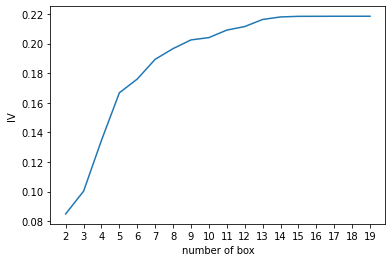


working_yr


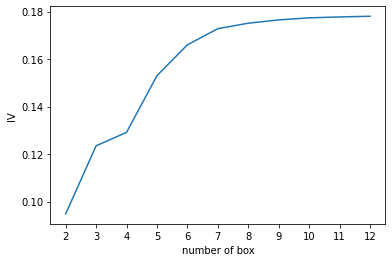


income_amount


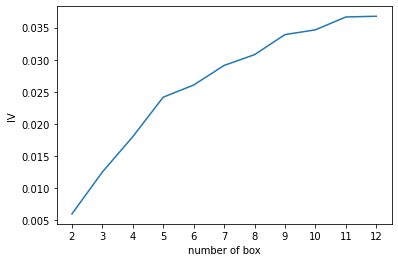

In [47]:
for i in ["age","working_yr","income_amount"]:
    model_data["qcut_{}".format(i)], updown = pd.qcut(model_data[i], retbins=True, q=20 ,duplicates='drop')
    coount_y0 = model_data[model_data["status"] == 0].groupby(by="qcut_{}".format(i)).count()["status"]
    coount_y1 = model_data[model_data["status"] == 1].groupby(by="qcut_{}".format(i)).count()["status"]

    num_bins = [*zip(updown,updown[1:].astype(int),coount_y0,coount_y1)]

    # for guarantee there is no 0 in the bins
    for a in range(20):
        for x in range(len(num_bins)-1):
            if 0 in num_bins[x][2:]:
                num_bins[x-1:x+1] = [(
                num_bins[x-1][0],
                num_bins[x][1],
                num_bins[x-1][2]+num_bins[x][2],
                num_bins[x-1][3]+num_bins[x][3])]
                break
    print("")        
    print(i)

    # Checking relationship between IV and number of Box
    plot_IV_BOX(num_bins)

In [48]:
# binning, limite to 5
model_data["qcut_age"], updown_age = pd.qcut(model_data["age"], retbins=True, q=5 )
model_data["qcut_working_yr"], updown_working_yr = pd.qcut(model_data["working_yr"], retbins=True, q=5 )
model_data["qcut_income_amount"], updown_income_amount = pd.qcut(model_data["income_amount"], retbins=True, q=5)

In [49]:
for i in ["qcut_age","qcut_working_yr","qcut_income_amount"]:
    updown = list(set(model_data[i]))
    updown.sort()
    model_data.replace(updown[0],pd.Interval(-np.inf,updown[0].right),inplace=True)
    model_data.replace(updown[-1],pd.Interval(updown[-1].left, np.inf),inplace=True)

In [50]:
for columns in ["age","working_yr","income_amount"]:
    updown = []
    for i in range(len(model_data["qcut_{}".format(columns)].value_counts().index)):
        updown.append(model_data["qcut_{}".format(columns)].value_counts().index[i].left)
    updown.append(np.inf)
    updown.sort()
    test_data["qcut_{}".format(columns)] = pd.cut(test_data[columns],updown)
    test_data.drop(columns =  columns)

In [51]:
display(get_feature_woe("qcut_working_yr"))
display(get_feature_woe("qcut_income_amount"))
display(get_feature_woe("qcut_age"))

model_data.drop(columns=["income_amount","age","working_yr"],inplace=True, errors="ignore")
test_data.drop(columns=["income_amount","age","working_yr"],inplace=True, errors="ignore")

min  max  count_0  count_1  total  percentage  \
features        class                                                           
qcut_working_yr (9.12, inf]     NaN  NaN     3091     1802   4893    0.200000   
                (3.285, 6.0]    NaN  NaN     2841     2699   5540    0.226446   
                (6.0, 9.12]     NaN  NaN     2054     2192   4246    0.173554   
                (-inf, 1.625]   NaN  NaN     2096     2797   4893    0.200000   
                (1.625, 3.285]  NaN  NaN     2065     2828   4893    0.200000   

                                bad_rate     good%      bad%       woe  
features        class                                                   
qcut_working_yr (9.12, inf]     0.368281  0.254466  0.146290  0.553577  
                (3.285, 6.0]    0.487184  0.233885  0.219110  0.065254  
                (6.0, 9.12]     0.516251  0.169095  0.177951 -0.051046  
                (-inf, 1.625]   0.571633  0.172553  0.227066 -0.274537  
                (1.625, 3.285]  0.577969  0.170001  0.229583 -0.300460

min  max  count_0  count_1  total  \
features           class                                                     
qcut_income_amount (202500.0, 270000.0]  NaN  NaN     2459     2280   4739   
                   (270000.0, inf]       NaN  NaN     1820     1844   3664   
                   (157500.0, 202500.0]  NaN  NaN     2341     2388   4729   
                   (117000.0, 157500.0]  NaN  NaN     3134     3285   6419   
                   (-inf, 117000.0]      NaN  NaN     2393     2521   4914   

                                         percentage  bad_rate     good%  \
features           class                                                  
qcut_income_amount (202500.0, 270000.0]    0.193705  0.481114  0.202437   
                   (270000.0, inf]         0.149765  0.503275  0.149831   
                   (157500.0, 202500.0]    0.193297  0.504969  0.192722   
                   (117000.0, 157500.0]    0.262375  0.511762  0.258006   
                   (-inf, 117000.0]        0.200858  0.513024  0.197003   

                                             bad%       woe  
features           class                                     
qcut_income_amount (202500.0, 270000.0]  0.185095  0.089559  
                   (270000.0, inf]       0.149700  0.000879  
                   (157500.0, 202500.0]  0.193863 -0.005899  
                   (117000.0, 157500.0]  0.266683 -0.033077  
                   (-inf, 117000.0]      0.204660 -0.038128

min  max  count_0  count_1  total  percentage  \
features class                                                         
qcut_age (37.0, 42.0]  NaN  NaN     2333     2014   4347    0.177682   
         (49.0, inf]   NaN  NaN     2489     2264   4753    0.194278   
         (42.0, 49.0]  NaN  NaN     2435     2544   4979    0.203515   
         (31.0, 37.0]  NaN  NaN     2523     2681   5204    0.212712   
         (-inf, 31.0]  NaN  NaN     2367     2815   5182    0.211813   

                       bad_rate     good%      bad%       woe  
features class                                                 
qcut_age (37.0, 42.0]  0.463308  0.192064  0.163501  0.161012  
         (49.0, inf]   0.476331  0.204907  0.183796  0.108727  
         (42.0, 49.0]  0.510946  0.200461  0.206527 -0.029812  
         (31.0, 37.0]  0.515181  0.207706  0.217649 -0.046762  
         (-inf, 31.0]  0.543227  0.194863  0.228527 -0.159360

In [52]:
# ALL WOE AND IV
woe = pd.DataFrame()
for i in list(model_data.drop(columns=["status"]).columns):
    woe_each = get_feature_woe(i)
    woe = woe.append(woe_each)

IV = pd.DataFrame(columns=["IV"])
for i in list(model_data.drop(columns=["status"]).columns):
    IV.loc[i] = get_iv(woe.loc[(i)])
display(IV.sort_values("IV",ascending = False))

,IV
income_type,0.129844
housing_type,0.120613
qcut_working_yr,0.094168
email,0.067369
occupation_type,0.044756
family_status,0.043764
children_count,0.040163
family_members,0.023500
education_type,0.022412
gender,0.015954


## 4 Mapping woe

In [53]:
train_woe =model_data.copy()
columns = train_woe.drop(columns=["status"]).columns

for f in list(columns):
    values = list(woe.loc[f].index.values)
    for i in range(len(values)):
        train_woe.replace({f:{values[i]:woe.loc[(f,values[i])]["woe"]}},inplace=True)

In [54]:
test_woe =test_data.copy()
columns = test_woe.drop(columns=["status"]).columns

for f in list(columns):
    values = list(woe.loc[f].index.values)
    for i in range(len(values)):
        test_woe.replace({f:{values[i]:woe.loc[(f,values[i])]["woe"]}},inplace=True)

## 5 Model

In [55]:
train_woe.dropna(inplace=True)
test_woe.dropna(inplace=True)

In [56]:

X_train = train_woe.drop(columns="status")
y_train= train_woe["status"]

X_test = test_woe.drop(columns="status")
y_test= test_woe["status"]

## 5.1  Logistic regression

Accuracy Score is 0.62747
      0     1
0  6749  5398
1  3716  8602


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

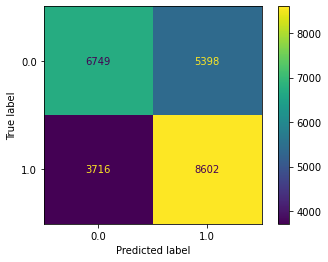

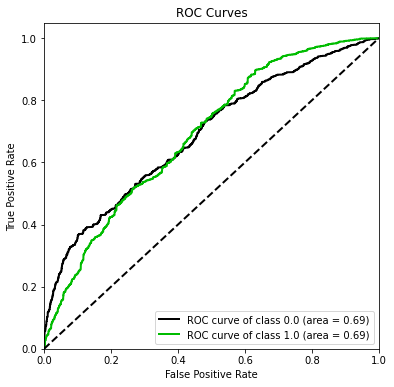

In [57]:
# Logistic regression
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt

lr = LR(max_iter=100)
lr.fit(X_train,y_train)
y_predict = lr.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(lr,X_test,y_test)

test_proba_df = pd.DataFrame(lr.predict_proba(X_test)) 
skplt.metrics.plot_roc(y_test, test_proba_df,plot_micro=False,figsize=(6,6),plot_macro=False)

In [58]:
#

## Scorecard
Score $=offset -Factor * \ln ($ odds $)$  
"Offset" and "Factor" are constant. The $log(odd) represents the probability of default, which is coefficient in the model. 

In the begin, two assumption required:
1) A socre under certian PD
2) Points to double the odds (PDO)

For example, if the score of $odd = \frac{1}{60}$ is 800 and $PDO=50$, the score of $odd = \frac{1}{30}$ is $850$  

$800=A-B * \ln \left(\frac{1}{60}\right)$

$850=A-B * \ln \left(\frac{1}{30}\right)$

In [59]:
B = 50/np.log(2)
A = 800 + B*np.log(1/60)

B,A

(72.13475204444818, 504.65547021957406)

The base score is $A-B * intercept$  
The score of feature is $-B * WOE_i * coeffient_i$

In [60]:
x= 0
coef = pd.DataFrame(range(len(X_test.columns)),index = X_test.columns,columns = ["coef"])
coef["coef"]= coef["coef"].astype("float")
for i in X_test.columns:
    coef.loc[i]["coef"] = float(lr.coef_[0][x])
    x = x+ 1

In [61]:
base_score = A - B*lr.intercept_ 
print(base_score)

for i in X_test.columns:
    print(i)
    print(woe["woe"].loc[i] * coef["coef"].loc[i] * B)
    print(" ")

[503.82540423]
gender
class
F   -4.587821
M    6.933418
Name: woe, dtype: float64
 
car
class
Y   -10.824293
N     7.540216
Name: woe, dtype: float64
 
realty
class
N    0.631752
Y   -0.352424
Name: woe, dtype: float64
 
children_count
class
2        -55.862686
over 3   -26.627487
1        -23.106577
0         15.028825
Name: woe, dtype: float64
 
income_type
class
Student / State servant / Pensioner   -90.323088
Commercial associate                    1.243655
Working                                 6.856821
Name: woe, dtype: float64
 
education_type
class
Lower secondary                                          -24.059993
Academic degree / Higher education / Incomplete higher    -5.932436
Secondary / secondary special                              2.905481
Name: woe, dtype: float64
 
family_status
class
Separated              -80.815682
Civil marriage         -11.442775
Single / not married    -5.227587
Married                  5.679661
Widow                   11.999089
Name: woe, dty

## 5.2 Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.90407
       0      1
0  10529   1618
1    729  11589


## 5.3 SVM

In [63]:
from sklearn import svm
model = svm.SVC(C = 0.8,
                kernel='linear')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))


Accuracy Score is 0.61843
      0     1
0  5344  6803
1  2532  9786


## 5.4 XGBoost

In [68]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.02, 
                      eval_metric = 'auc',
                      use_label_encoder=False,   
                      seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.9516
       0      1
0  11373    774
1    410  11908


## 5.5 lightgbm

In [65]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(num_leaves=31,
                       max_depth=8, 
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8
                      )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.8645
      0      1
0  9618   2529
1   786  11532


## 5.6 Catboost

In [66]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

0:	learn: 0.5086460	total: 1.82s	remaining: 7m 33s
25:	learn: 0.0775073	total: 32s	remaining: 4m 36s
50:	learn: 0.0576118	total: 52.1s	remaining: 3m 23s
75:	learn: 0.0487321	total: 1m 26s	remaining: 3m 17s
100:	learn: 0.0452570	total: 2m	remaining: 2m 57s
125:	learn: 0.0435217	total: 2m 35s	remaining: 2m 33s
150:	learn: 0.0424327	total: 3m 16s	remaining: 2m 9s
175:	learn: 0.0416583	total: 3m 53s	remaining: 1m 38s
200:	learn: 0.0410973	total: 4m 25s	remaining: 1m 4s
225:	learn: 0.0406998	total: 4m 50s	remaining: 30.9s
249:	learn: 0.0404489	total: 5m 11s	remaining: 0us
CatBoost Accuracy Score is 0.98406
       0      1
0  11918    229
1    161  12157
